In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

folder_path = Path('final_data')
common_props_raw: pd.DataFrame = pd.read_csv(folder_path / 'commonProps.csv')
time_in_system_raw: pd.DataFrame = pd.read_csv(folder_path / 'timeInSystem.csv')
time_wait_allocate_raw: pd.DataFrame = pd.read_csv(folder_path / 'timeWaitAllocate.csv')
common_props_raw.sort_values(by='timePoint', inplace=True)
time_in_system_raw.sort_values(by='timePoint', inplace=True)
time_wait_allocate_raw.sort_values(by='timePoint', inplace=True)

In [3]:
import numpy as np
from array import array
from typing import Sequence

def calculate_means_through_time(
    time_points: pd.Series,
    values: pd.Series
) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    values_through_time = array('d')

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += value * delay
        values_through_time.append(value_sum / delay_sum)

    return values_through_time

def calculate_stddevs_through_time(
    time_points: pd.Series,
    values: pd.Series,
    means: array[float]
) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    stddevs_through_time: array[float] = array('d')

    for time_point, value, mean in zip(time_points.iloc[1:], values, means):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += ((value - mean) ** 2) * delay
        stddevs_through_time.append(np.sqrt(value_sum / delay_sum))

    return stddevs_through_time


def calculate_mean(time_points: pd.Series, values: pd.Series) -> float:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += value * delay

    return value_sum / delay_sum

def calculate_std_dev(time_points: pd.Series, values: pd.Series, mean: float) -> float:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += ((value - mean) ** 2) * delay

    return np.sqrt(value_sum / delay_sum)

In [4]:
from collections import deque
import attr

@attr.frozen
class PropertyMeanStdDev:
    mean: array[float]
    stdDev: array[float]

def calc_mean_stddev_through_time(time_points: pd.Series, props: pd.Series) -> PropertyMeanStdDev:
    means = calculate_means_through_time(time_points, props)
    return PropertyMeanStdDev(
        means,
        calculate_stddevs_through_time(time_points, props, means)
    )

time_points_mat: deque[Sequence[float]] = deque()
disk_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
io_channel_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
processors_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
use_of_page_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
total_wait_allocate_stddev_mat: deque[PropertyMeanStdDev] = deque()

time_in_system_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
time_in_system_time_points_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_time_points_mat: deque[PropertyMeanStdDev] = deque()

for run_number, common_props_raw_indexed in common_props_raw.groupby(by='runNumber'):
    time_points = common_props_raw_indexed['timePoint'][:-1]
    disk_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['diskLoad']))
    io_channel_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['ioChannelLoad']))
    processors_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['processorsLoad']))
    use_of_page_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['useOfPage']))
    total_wait_allocate_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['totalWaitAllocate']))
    time_points_mat.append(time_points[:-1])

for run_number, time_in_system_raw_indexed in time_in_system_raw.groupby(by='runNumber'):
    time_in_system_time_points = time_in_system_raw_indexed['timePoint']
    time_in_system_mean_stddev_mat.append(calc_mean_stddev_through_time(time_in_system_time_points, time_in_system_raw_indexed['timeInSystem']))
    time_in_system_time_points_mat.append(time_in_system_time_points.iloc[:-1])

for run_number, time_wait_allocate_raw_indexed in time_wait_allocate_raw.groupby(by='runNumber'):
    time_wait_allocate_time_points = time_wait_allocate_raw_indexed['timePoint']
    time_wait_allocate_mean_stddev_mat.append(calc_mean_stddev_through_time(time_wait_allocate_time_points, time_wait_allocate_raw_indexed['timeWaitAllocate']))
    time_wait_allocate_time_points_mat.append(time_wait_allocate_time_points.iloc[:-1])

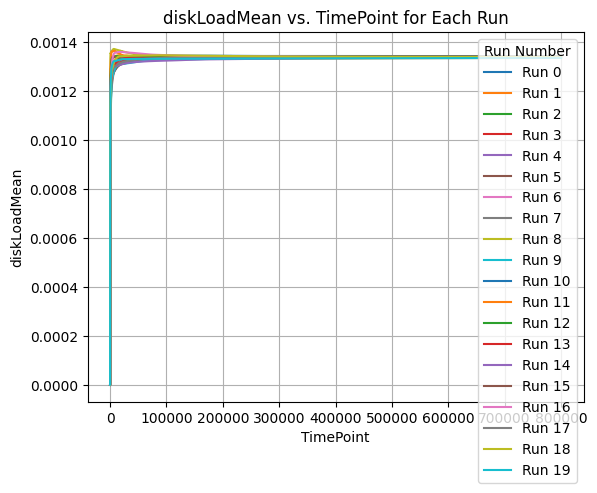

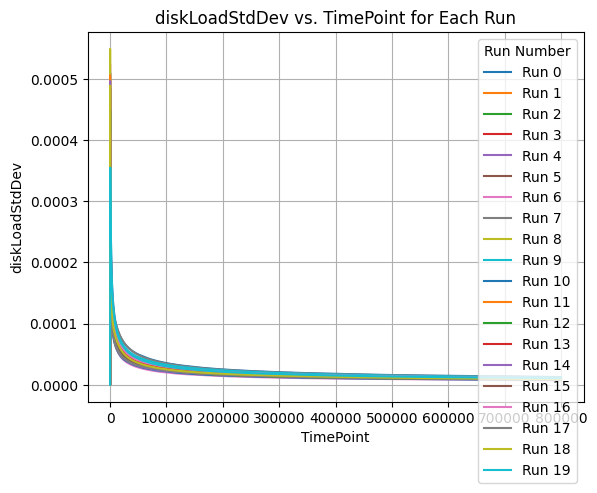

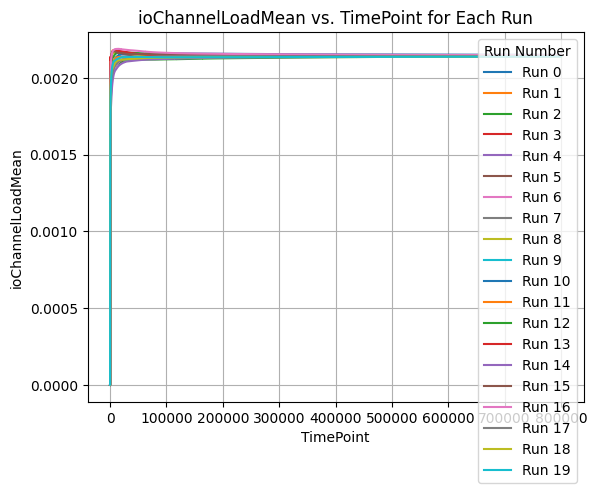

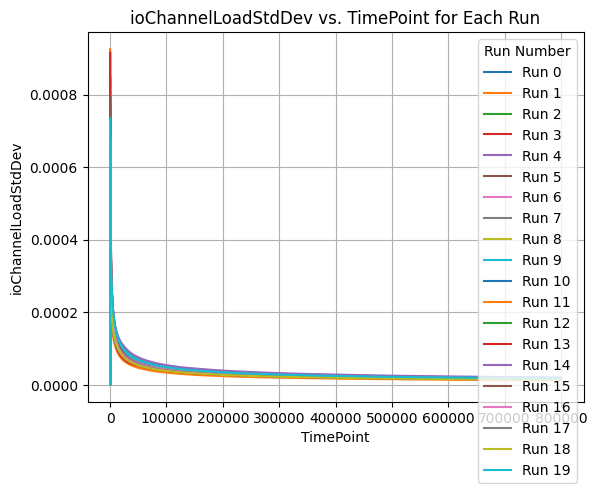

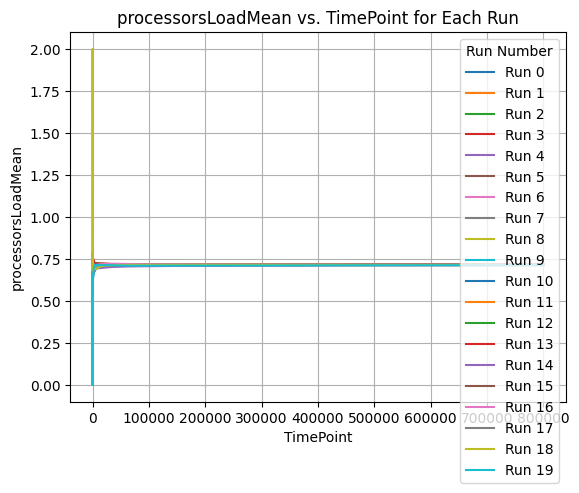

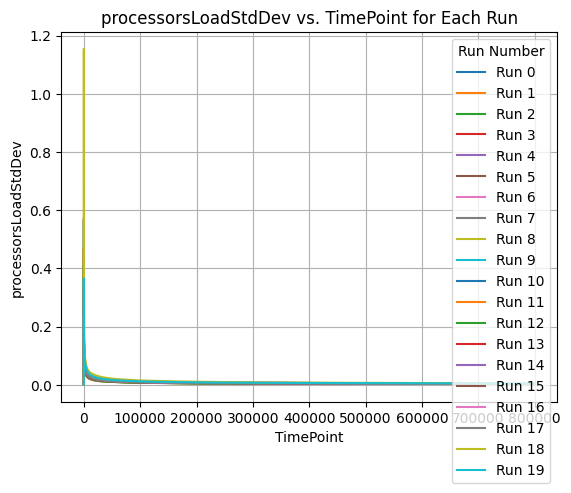

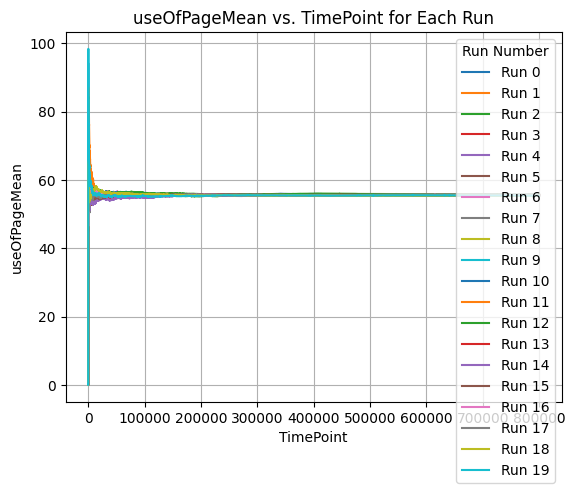

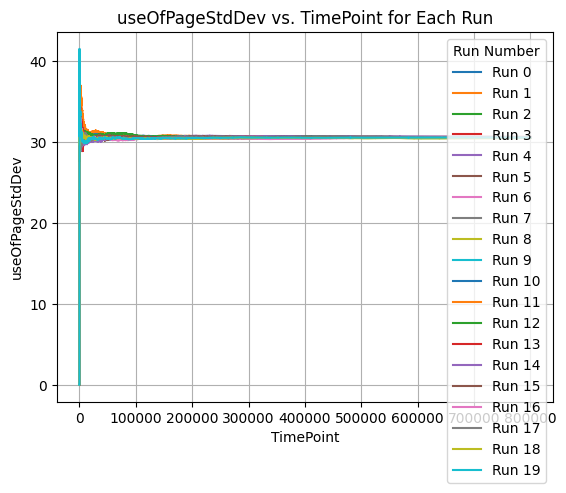

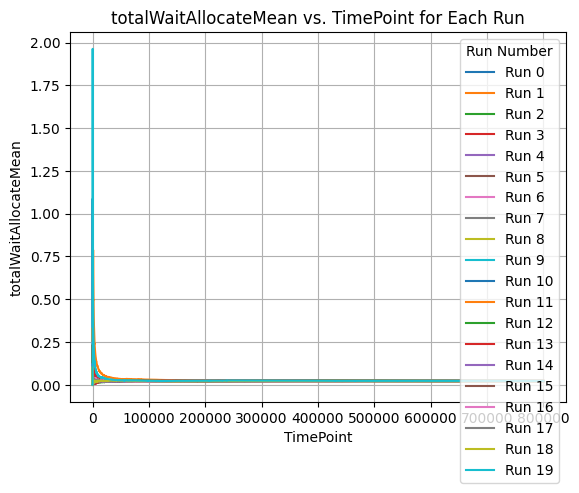

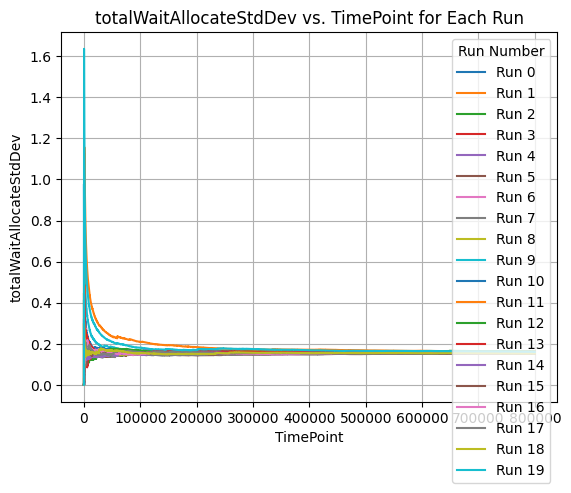

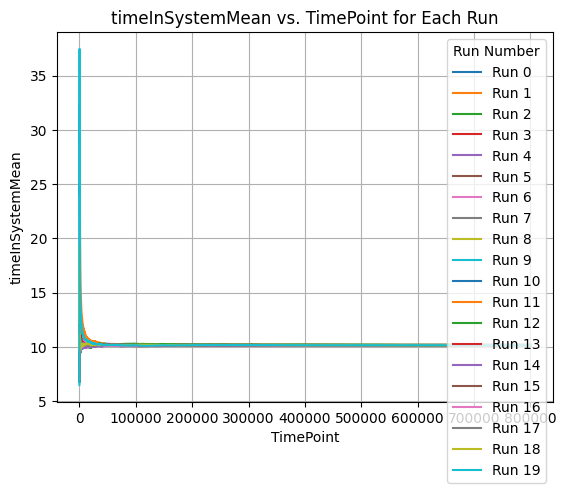

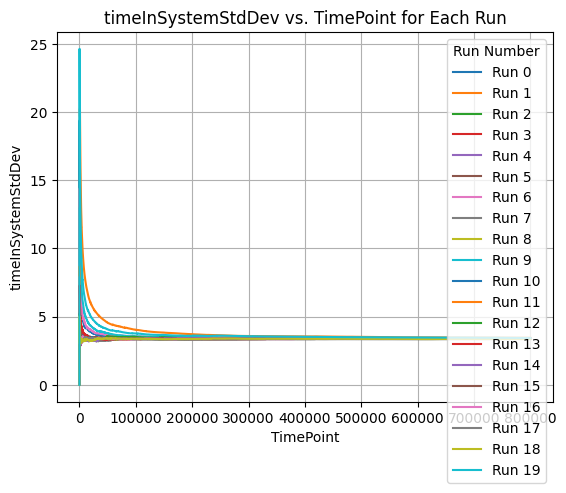

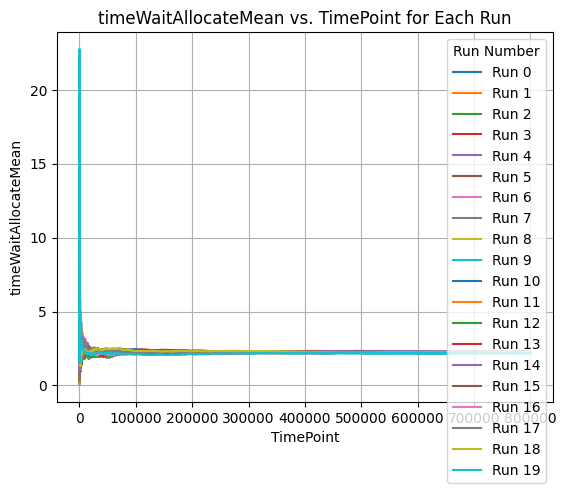

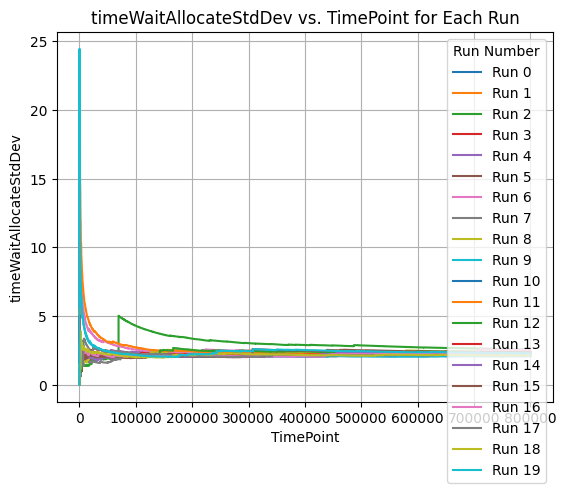

In [45]:
from typing import Iterable

def plot_matrix(time_points_mat: Iterable[float], value_mat: Iterable[float], ylabel: str):
    for run_num, row in enumerate(zip(time_points_mat, value_mat)):
        time_points_row = row[0]
        value_row = row[1]
        plt.plot(time_points_row, value_row, label=f'Run {run_num}')

    plt.title(f'{ylabel} vs. TimePoint for Each Run')
    plt.xlabel('TimePoint')
    plt.ylabel(ylabel)
    plt.legend(title='Run Number', loc='upper right')
    plt.grid(True)
    plt.savefig(fname=f'{ylabel}.svg', format='svg')
    plt.show()

def plot_matrix_mean_std_dev(time_points_mat: Sequence[float], value_mat: deque[PropertyMeanStdDev], ylabel: str):
    plot_matrix(time_points_mat, (v.mean for v in value_mat), ylabel + 'Mean')
    plot_matrix(time_points_mat, (v.stdDev for v in value_mat), ylabel + 'StdDev')

plot_matrix_mean_std_dev(time_points_mat, disk_load_mean_stddev_mat, 'diskLoad')
plot_matrix_mean_std_dev(time_points_mat, io_channel_load_mean_stddev_mat, 'ioChannelLoad')
plot_matrix_mean_std_dev(time_points_mat, processors_load_mean_stddev_mat, 'processorsLoad')
plot_matrix_mean_std_dev(time_points_mat, use_of_page_mean_stddev_mat, 'useOfPage')
plot_matrix_mean_std_dev(time_points_mat, total_wait_allocate_stddev_mat, 'totalWaitAllocate')
plot_matrix_mean_std_dev(time_in_system_time_points_mat, time_in_system_mean_stddev_mat, 'timeInSystem')
plot_matrix_mean_std_dev(time_wait_allocate_time_points_mat, time_wait_allocate_mean_stddev_mat, 'timeWaitAllocate')

In [6]:
transit_period_start_at = 600000

In [7]:
common_props_stable = common_props_raw[common_props_raw['timePoint'] > transit_period_start_at]
time_in_system_stable = time_in_system_raw[time_in_system_raw['timePoint'] > transit_period_start_at]
time_wait_allocate_stable = time_wait_allocate_raw[time_wait_allocate_raw['timePoint'] > transit_period_start_at]

In [8]:
data_stable_mean: dict[str, array[float]] = {}
data_stable_stddev: dict[str, array[float]] = {}

def append_last_cell(
    dest_mean: dict[str, array[float]],
    dest_stddev: dict[str, array[float]],
    src: pd.DataFrame, col: str
) -> None:
    if not col in dest_mean:
        dest_mean[col] = array('d')
        dest_stddev[col] = array('d')
    mean = calculate_mean(src['timePoint'], src[col])
    dest_mean[col].append(mean)
    dest_stddev[col].append(calculate_std_dev(src['timePoint'], src[col], mean))

for run_number, stable_run in common_props_stable.groupby('runNumber'):
    append_last_cell(data_stable_mean, data_stable_stddev, stable_run, 'diskLoad')
    append_last_cell(data_stable_mean, data_stable_stddev, stable_run, 'ioChannelLoad')
    append_last_cell(data_stable_mean, data_stable_stddev, stable_run, 'processorsLoad')
    append_last_cell(data_stable_mean, data_stable_stddev, stable_run, 'totalWaitAllocate')
    append_last_cell(data_stable_mean, data_stable_stddev, stable_run, 'useOfPage')

for run_number, stable_run in time_in_system_stable.groupby('runNumber'):
    append_last_cell(data_stable_mean, data_stable_stddev, stable_run, 'timeInSystem') 

for run_number, stable_run in time_wait_allocate_stable.groupby('runNumber'):
    append_last_cell(data_stable_mean, data_stable_stddev, stable_run, 'timeWaitAllocate')

data_stable_mean: pd.DataFrame = pd.DataFrame(data_stable_mean)
data_stable_stddev: pd.DataFrame = pd.DataFrame(data_stable_stddev)

In [9]:
rename_dict = {
    'diskLoad': 'Завантаження дисків',
    'ioChannelLoad': 'Завантаження каналу введення-виведення',
    'processorsLoad': 'Завантаження процесорів',
    'totalWaitAllocate': "Кількість завдань в очікуванні пам'яті",
    'useOfPage': 'Кількість зайнятих сторінок',
    'timeInSystem': 'Час завдання в системі',
    'timeWaitAllocate': "Час виділення пам'яті",
}

In [10]:
ukr_data_stable_mean = data_stable_mean.rename(columns=rename_dict)
ukr_data_stable_stddev = data_stable_stddev.rename(columns=rename_dict)
ukr_data_stable_mean.to_csv('ukr_data_stable_mean.csv', index=True, index_label='Номер прогону')
ukr_data_stable_stddev.to_csv('ukr_data_stable_stddev.csv', index=True, index_label='Номер прогону')

In [27]:
global_mean: dict[str, float] = {}
global_stddev: dict[str, float] = {}

def update_global_mean_stddev(
    dest_mean: dict[str, float],
    dest_stddev: dict[str, float],
    src: pd.DataFrame,
    col: str
) -> None:
    mean = calculate_mean(src['timePoint'], src[col])
    dest_mean[col] = mean
    dest_stddev[col] = calculate_std_dev(src['timePoint'], src[col], mean)

for run_number, stable_run in common_props_stable.groupby('runNumber'):
    update_global_mean_stddev(global_mean, global_stddev, stable_run, 'diskLoad')
    update_global_mean_stddev(global_mean, global_stddev, stable_run, 'ioChannelLoad')
    update_global_mean_stddev(global_mean, global_stddev, stable_run, 'processorsLoad')
    update_global_mean_stddev(global_mean, global_stddev, stable_run, 'totalWaitAllocate')
    update_global_mean_stddev(global_mean, global_stddev, stable_run, 'useOfPage')

for run_number, stable_run in time_in_system_stable.groupby('runNumber'):
    update_global_mean_stddev(global_mean, global_stddev, stable_run, 'timeInSystem') 

for run_number, stable_run in time_wait_allocate_stable.groupby('runNumber'):
    update_global_mean_stddev(global_mean, global_stddev, stable_run, 'timeWaitAllocate')

In [30]:
global_mean: pd.Series = pd.Series(global_mean)
global_stddev: pd.Series = pd.Series(global_stddev)

In [42]:
global_mean_stddev = pd.concat([global_mean, global_stddev], axis=1)
global_mean_stddev.rename(columns={0: 'Середнє значення', 1: 'Середньоквадратичне відхилення'}, inplace=True)
global_mean_stddev.rename(index=rename_dict, inplace=True)
global_mean_stddev.to_csv('global_mean_stddev.csv', index=True, index_label='Назва вихідного параметра')
global_mean_stddev

,Середнє значення,Середньоквадратичне відхилення
Завантаження дисків,0.001338,5.164306e-07
Завантаження каналу введення-виведення,0.002141,5.826439e-07
Завантаження процесорів,0.713642,2.284170e-04
Кількість завдань в очікуванні пам'яті,0.021118,1.499306e-01
Кількість зайнятих сторінок,55.119726,3.054291e+01
Час завдання в системі,10.103187,3.308639e+00
Час виділення пам'яті,2.173984,2.018925e+00


In [46]:
def show_hist(data, col_name: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.hist(data[col_name], bins=100, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.savefig(fname=f'hist{col_name}.svg', format='svg')
    plt.grid(True)

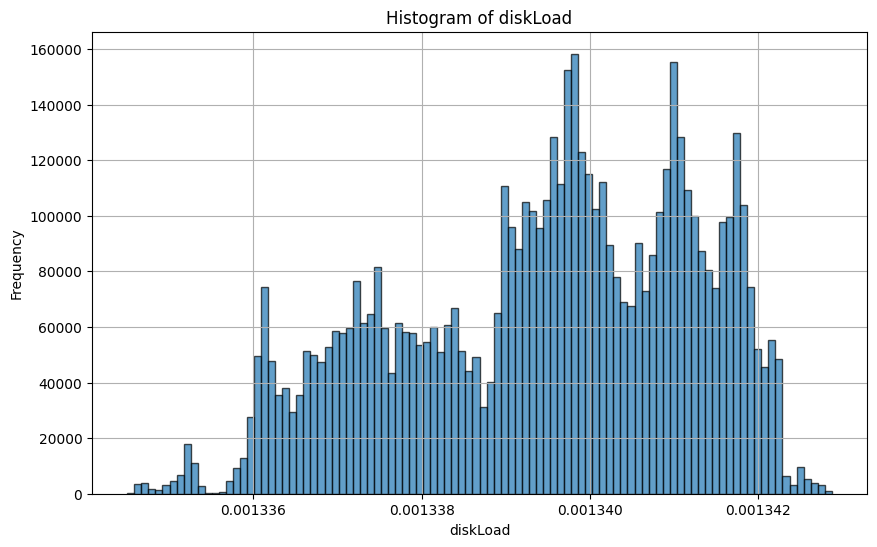

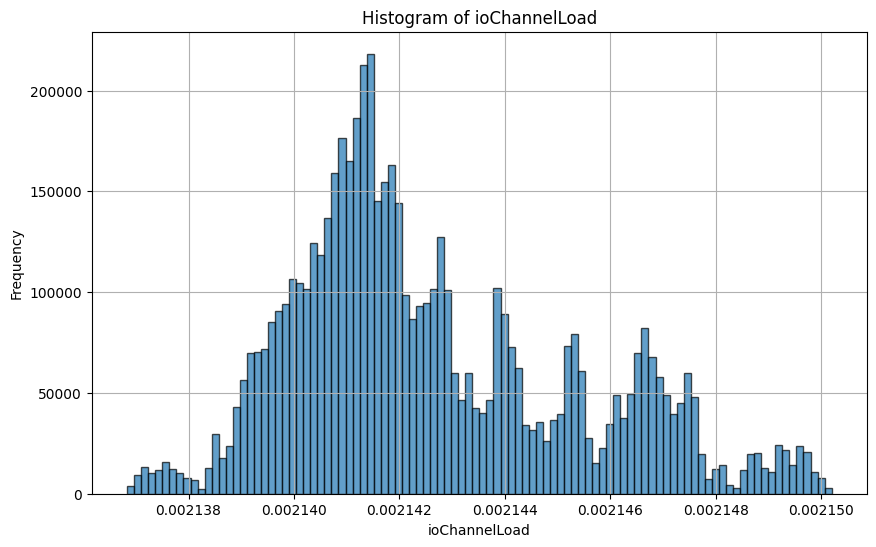

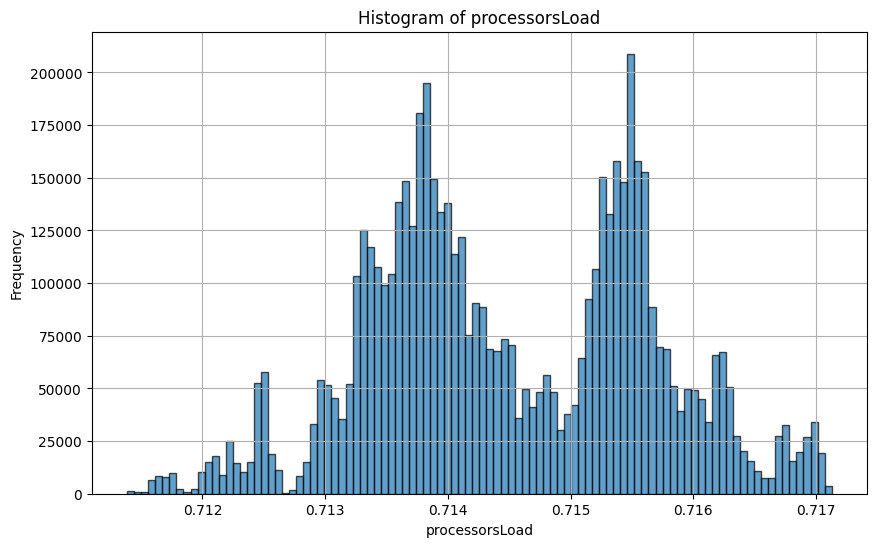

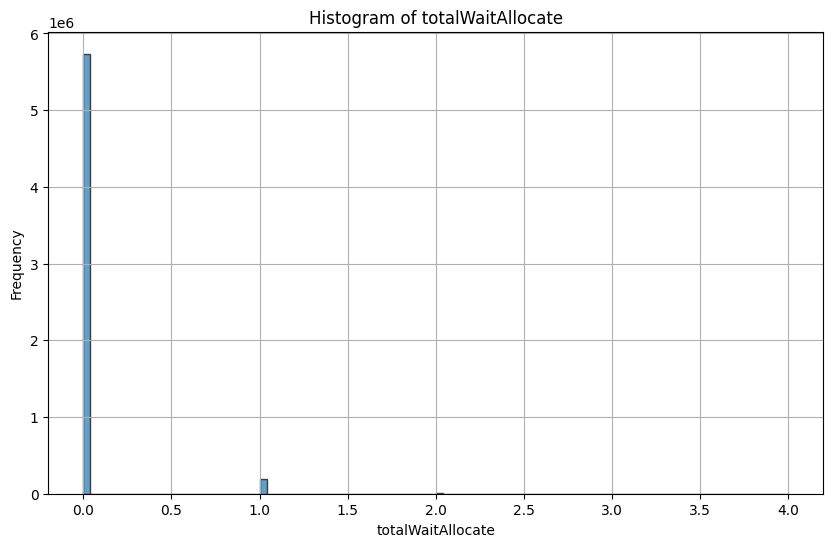

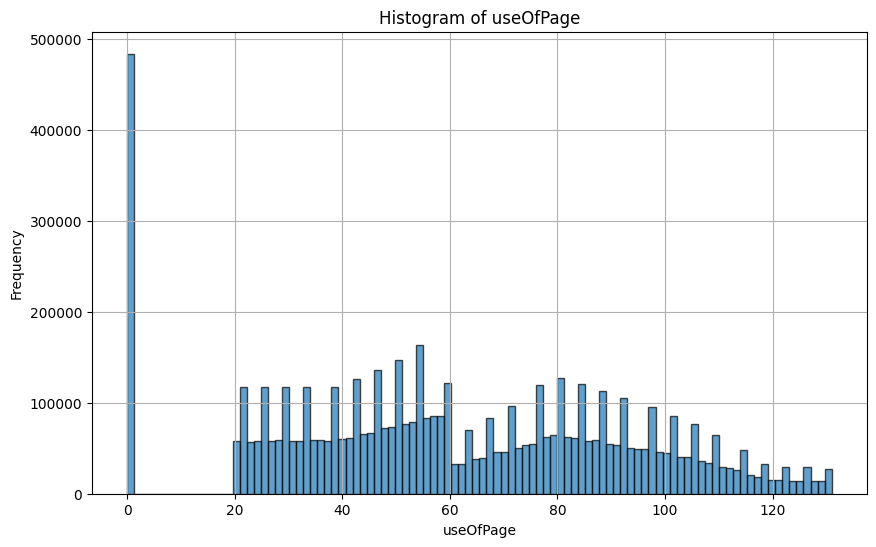

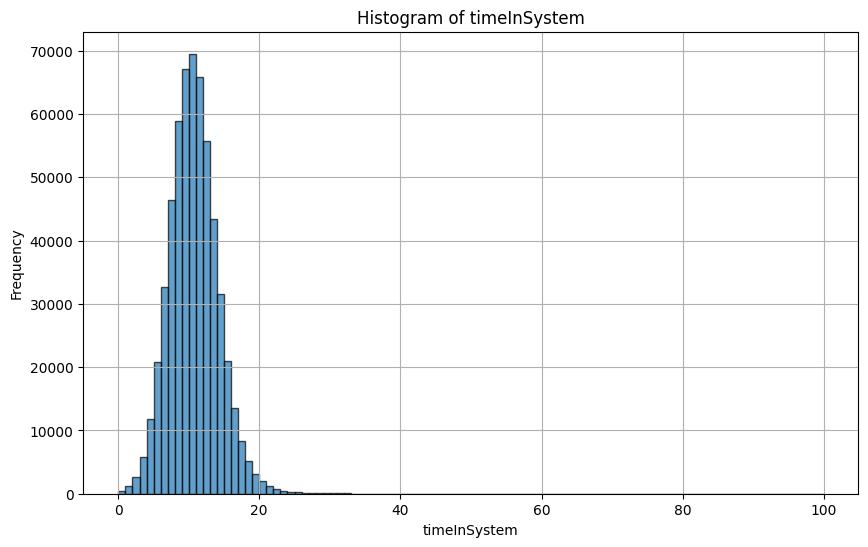

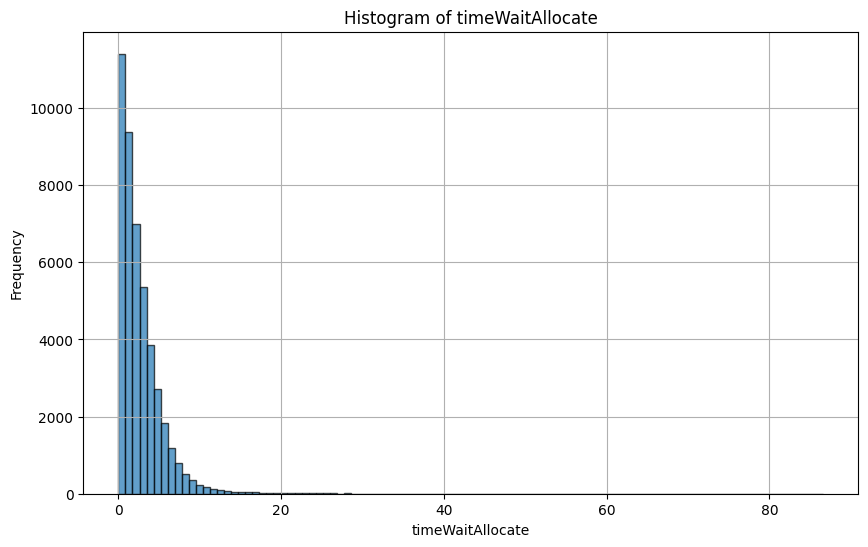

In [47]:
show_hist(common_props_stable, 'diskLoad')
show_hist(common_props_stable, 'ioChannelLoad')
show_hist(common_props_stable, 'processorsLoad')
show_hist(common_props_stable, 'totalWaitAllocate')
show_hist(common_props_stable, 'useOfPage')
show_hist(time_in_system_stable, 'timeInSystem')
show_hist(time_wait_allocate_stable, 'timeWaitAllocate')

3.478472579947688


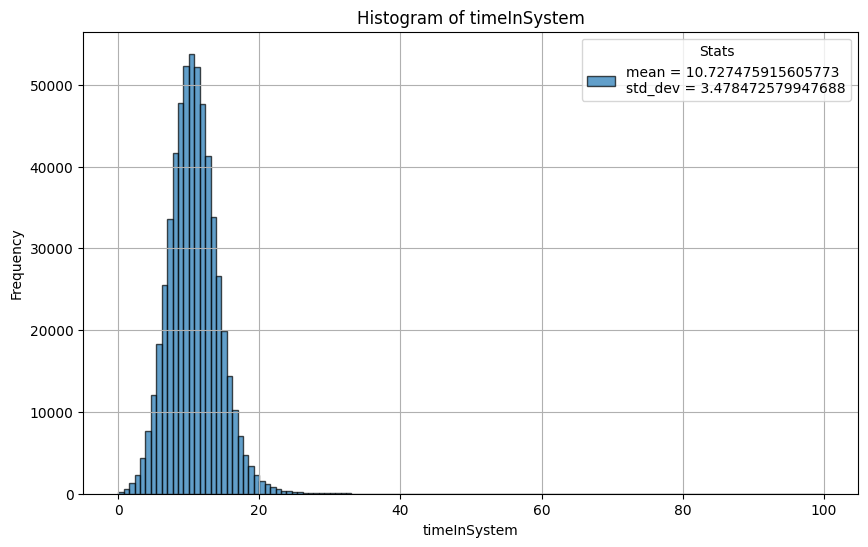

In [56]:
time_in_system_stable_filtered = time_in_system_stable
time_in_system_stable_filtered_mean = calculate_mean(
    time_in_system_stable_filtered['timePoint'],
    time_in_system_stable_filtered['timeInSystem']
)
time_in_system_stable_filtered_std_dev = calculate_std_dev(
    time_in_system_stable_filtered['timePoint'],
    time_in_system_stable_filtered['timeInSystem'],
    time_in_system_stable_filtered_mean
)
print(time_in_system_stable_filtered_std_dev)

plt.figure(figsize=(10, 6))
plt.hist(
    time_in_system_stable_filtered['timeInSystem'],
    bins=130,
    edgecolor='k',
    alpha=0.7,
    label=f'mean = {time_in_system_stable_filtered_mean}\nstd_dev = {time_in_system_stable_filtered_std_dev}'
)
plt.title(f'Histogram of timeInSystem')
plt.xlabel('timeInSystem')
plt.ylabel('Frequency')
plt.legend(title='Stats')
plt.grid(True)

In [57]:
from typing import Sequence
import numpy as np
from scipy.stats import chi2

def chi_squared_normality_test(data: Sequence[float], mean: float, std_dev: float) -> bool:
    # Calculate the number of bins using Sturges' rule
    num_bins = int(np.ceil(1 + 3.322 * np.log10(len(data))))
    
    # Create the histogram of the data
    observed_counts, bin_edges = np.histogram(data, bins=num_bins)
    
    # Calculate expected frequencies for a normal distribution
    expected_counts = []
    for i in range(len(bin_edges) - 1):
        # Calculate the cumulative probability for the bin range
        bin_prob = (
            (1 / (std_dev * np.sqrt(2 * np.pi))) *
            (np.exp(-0.5 * ((bin_edges[i + 1] - mean) / std_dev) ** 2) - 
             np.exp(-0.5 * ((bin_edges[i] - mean) / std_dev) ** 2))
        )
        expected_counts.append(bin_prob * len(data))
    
    # Perform chi-squared statistic
    expected_counts = np.array(expected_counts)
    chi_squared_stat = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
    
    # Degrees of freedom = (number of bins - 1 - number of estimated parameters)
    degrees_of_freedom = num_bins - 1 - 2
    
    # Find the critical value for the chi-squared distribution
    critical_value = chi2.ppf(0.95, degrees_of_freedom)
    
    # Check if the chi-squared statistic is within the critical range
    return chi_squared_stat < critical_value

In [58]:
time_in_system_stable_filtered_is_normal = chi_squared_normality_test(
    time_in_system_stable_filtered['timeInSystem'],
    time_in_system_stable_filtered_mean,
    time_in_system_stable_filtered_std_dev
)
time_in_system_stable_filtered_is_normal

True

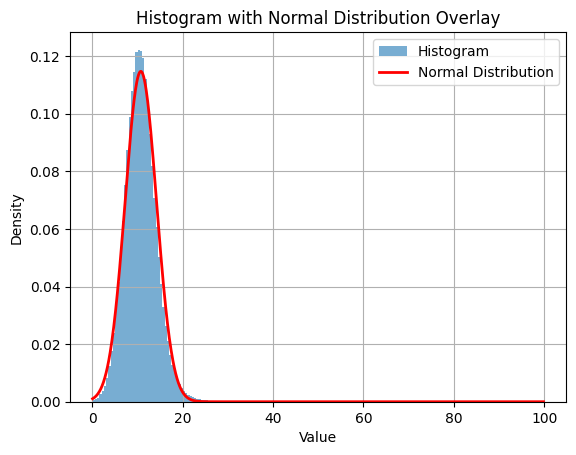

In [64]:
from scipy.stats import norm

count, bins, _ = plt.hist(time_in_system_stable_filtered['timeInSystem'], bins=200, density=True, alpha=0.6, label='Histogram')
x = np.linspace(bins[0], bins[-1], 1000)
pdf = norm.pdf(
    x,
    time_in_system_stable_filtered_mean,
    time_in_system_stable_filtered_std_dev
)
plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution')
plt.title('Histogram with Normal Distribution Overlay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig(fname=f'histNormTimeInSystem.svg', format='svg')
plt.show()

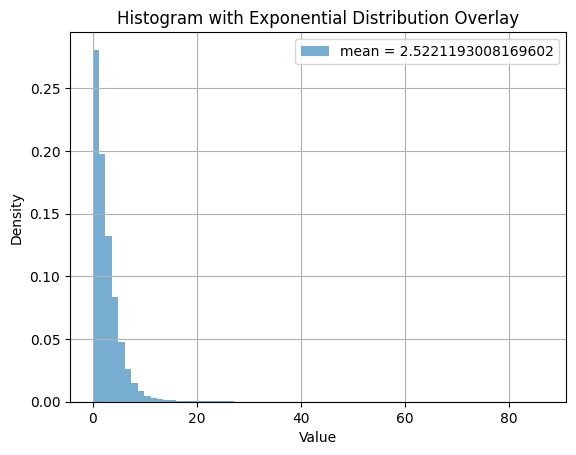

In [65]:
from scipy.stats import expon

time_wait_allocate_stable_filtered = time_wait_allocate_stable

time_wait_allocate_stable_filtered_mean = calculate_mean(
    time_wait_allocate_stable_filtered['timePoint'],
    time_wait_allocate_stable_filtered['timeWaitAllocate']
)
time_wait_allocate_stable_filtered_std_dev = calculate_std_dev(
    time_wait_allocate_stable_filtered['timePoint'],
    time_wait_allocate_stable_filtered['timeWaitAllocate'],
    time_wait_allocate_stable_filtered_mean
)

count, bins, _ = plt.hist(
    time_wait_allocate_stable_filtered['timeWaitAllocate'],
    bins=70,
    density=True,
    alpha=0.6,
    label=f'mean = {time_wait_allocate_stable_filtered_mean}'
)
plt.title('Histogram with Exponential Distribution Overlay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
def chi_squared_exponential_test(data: Sequence[float], mean: float, alpha: float = 0.05) -> bool:
    # Sort data and calculate the number of bins
    sorted_data = np.sort(data)
    n = len(data)
    bin_width = 2 / np.sqrt(n)  # Rule of thumb for bin width in exponential distribution
    bins = int(np.ceil(1 / bin_width))
    # Create bin edges and calculate expected frequencies
    max_data = max(sorted_data)
    bin_edges = np.linspace(0, max_data, bins + 1)
    observed_counts, _ = np.histogram(sorted_data, bins=bin_edges)
    # Calculate expected frequencies for exponential distribution
    expected_counts = np.diff(len(data) * (1 - np.exp(-bin_edges / mean)))
    # Calculate chi-squared statistic
    chi_squared_stat = np.sum((observed_counts - expected_counts)**2 / expected_counts)
    # Degrees of freedom
    degrees_of_freedom = bins - 1
    # Compute the p-value
    p_value = 1 - chi2.cdf(chi_squared_stat, df=degrees_of_freedom)
    return p_value < alpha

In [67]:
chi_squared_exponential_test(
    time_wait_allocate_stable_filtered['timeWaitAllocate'],
    time_wait_allocate_stable_filtered_mean,
    0.05
)

True

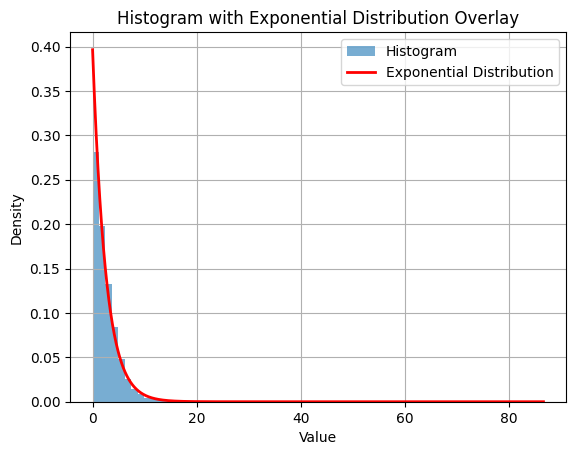

In [69]:
count, bins, _ = plt.hist(time_wait_allocate_stable_filtered['timeWaitAllocate'], bins=70, density=True, alpha=0.6, label='Histogram')
x = np.linspace(bins[0], bins[-1], 1000)

pdf = expon.pdf(x, scale=time_wait_allocate_stable_filtered_mean)
plt.plot(x, pdf, 'r-', lw=2, label='Exponential Distribution')
plt.title('Histogram with Exponential Distribution Overlay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig(fname=f'histExpTimeWaitAllocate.svg', format='svg')
plt.show()

In [75]:
use_page_series = common_props_stable['useOfPage']

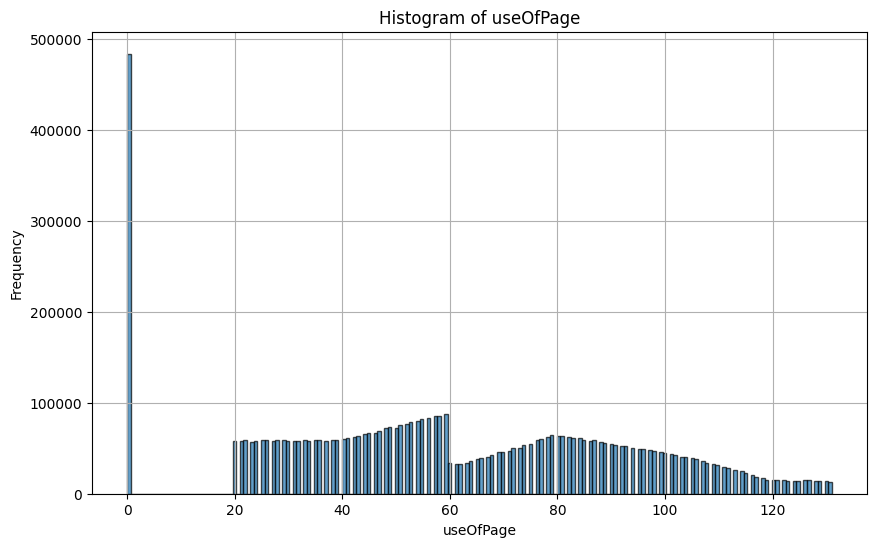

In [78]:
plt.figure(figsize=(10, 6))
plt.hist(use_page_series, bins=200, edgecolor='k', alpha=0.7)
plt.title(f'Histogram of useOfPage')
plt.xlabel('useOfPage')
plt.ylabel('Frequency')
plt.savefig(fname=f'histuseOfPage.svg', format='svg')
plt.grid(True)